- Use GPyTorch
- Eclipsing binary + Pulsation + noise
- Remove the eclipsing binary signal (using periodic window) and model the rest of the signal
- From the simulations

In [1]:
import os
import sys
import math
import torch
import gpytorch
%load_ext autoreload
%autoreload 2

import numpy as np
# Plotting tools
from matplotlib import pyplot as plt
# we use the following for plotting figures in jupyter
%matplotlib inline

import warnings
warnings.filterwarnings('ignore')

from astropy.timeseries import LombScargle
import pandas as pd
pd.set_option('precision', 0)
pd.set_option('display.float_format', lambda x: '%.16f' % x)

# Start the notebook from the root of the project
if 'notebooks' in os.getcwd():
    os.chdir(os.path.dirname(os.getcwd()))
    if os.getcwd().endswith('notebooks'):
        os.chdir(os.path.dirname(os.getcwd()))

# Local imports (i.e., my code) from the src folder
sys.path.insert(0, os.path.join(os.getcwd(), 'src'))

import clip_windows
import experiment_util
from plot_helpers import *
plotter = PlotUtilGPyTorch()

Read the first time series

In [2]:
USE_CUDA = False
#if torch.cuda.device_count() > 0:
#    torch.cuda.set_device(0)
#    print("USE GPU")

In [3]:
# Make the notebook use the whole screen width
from IPython.display import display, HTML

display(HTML(data="""
<style>
    div#notebook-container    { width: 95%; }
    div#menubar-container     { width: 65%; }
    div#maintoolbar-container { width: 99%; }
</style>
"""))

# 1. Exploratory
Plot the data

In [4]:
df = pd.read_csv("./simulations/sim_023_lc.dat",sep=' ', header = None, names=['Time', 'LC', 'N'], index_col=False, float_precision='round_trip')
df.dtypes

Time    float64
LC      float64
N       float64
dtype: object

In [5]:
X, Y, N = df['Time'].tolist(), df['LC'].tolist(), df['N'].tolist()
X, Y, N = np.array(X), np.array(Y), np.array(N)

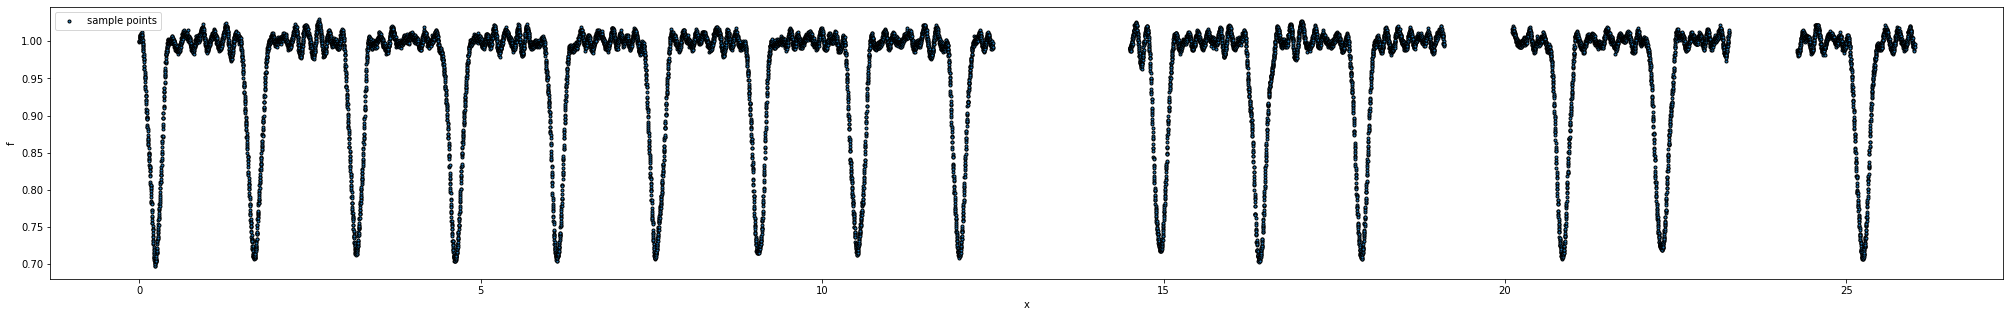

In [6]:
plotter.plot_data(X, Y)

array([0.        , 0.67695924, 0.68465196, 0.66926652, 1.3616112 ])

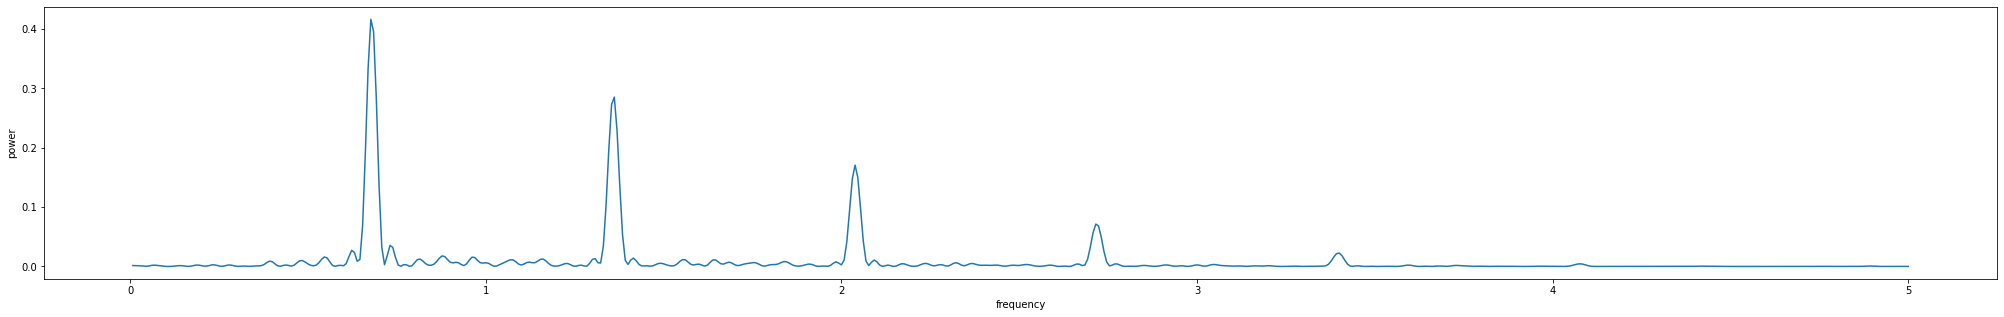

In [7]:
frequencies, power = plotter.plot_lomb_scargle_periodogram(X, Y, 0.0, 5)
frequencies[np.argsort(power)[::-1][:5]]

In [8]:
# 11300 is the complete first envelope
N_part=9000

In [9]:
X_part=X[:N_part]
Y_part=Y[:N_part]

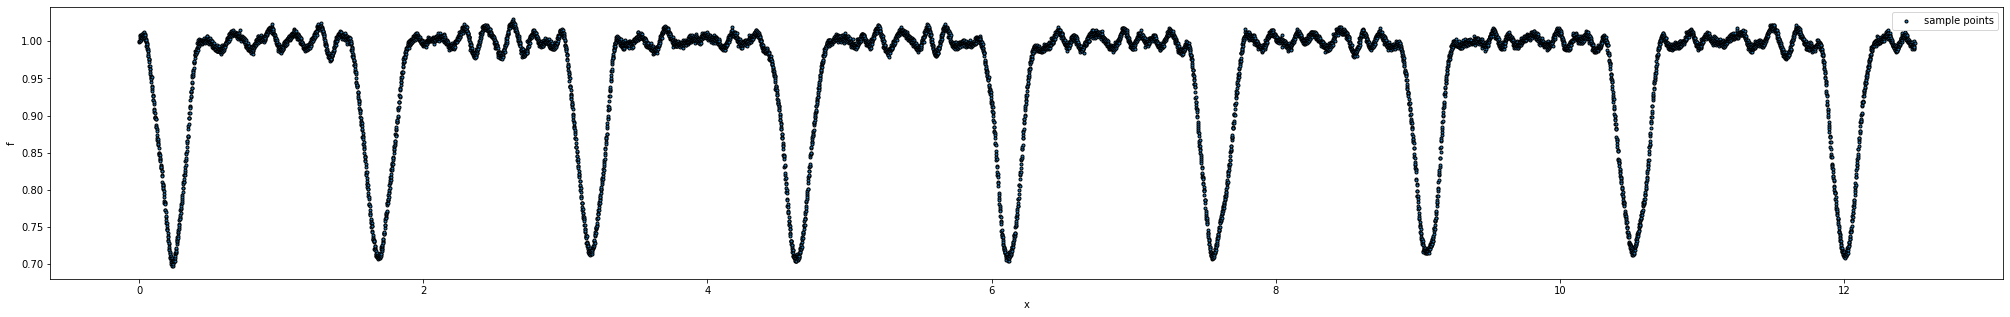

In [10]:
plotter.plot_data(X_part, Y_part)

# 2. Processing


Compose a Gaussian Process from a reasonable guess of kernels

In [11]:
X_part=torch.tensor(X_part)
Y_part=torch.tensor(Y_part)

In [12]:
# Predict evenly spaced points on our time-axis
X_part_smooth = torch.tensor(np.linspace(X_part.min(), X_part.max(), N_part))

In [13]:
sample_period = X[1] - X[0]
first_prim_eclipse_date = X_part[0] + (+6) * sample_period
first_sec_eclipse_date = X_part[0] + (+1100) * sample_period
# Take the frequency with the highest amplitude from the periodogram!!
eclipse_period = 1/0.67695924
print(eclipse_period)

window_size = 275  # todo: window size in duration
eclipse_duration = window_size * sample_period
X_part_window, Y_part_window = clip_windows.clip_periodic_windows(X_part, Y_part, eclipse_duration,
                                                     eclipse_period, 
                                                     first_prim_eclipse_date, first_sec_eclipse_date
                                                    )

1.477193811550604


In [14]:
# We have all timestamps with observations in X_part
# X_part_window is X_part minus the masked out eclipses
# If we want to plot the mask, subtract X_part_window from X_part and assume
# observations of amplitude 1 at those timestamps
a=X_part.cpu().numpy()
b=X_part_window.cpu().numpy()
X_mask=a
Y_mask=np.zeros(shape=Y_part.shape)
X_mask_idcs=np.searchsorted(a, np.setdiff1d(a, b))
Y_mask[X_mask_idcs]=1

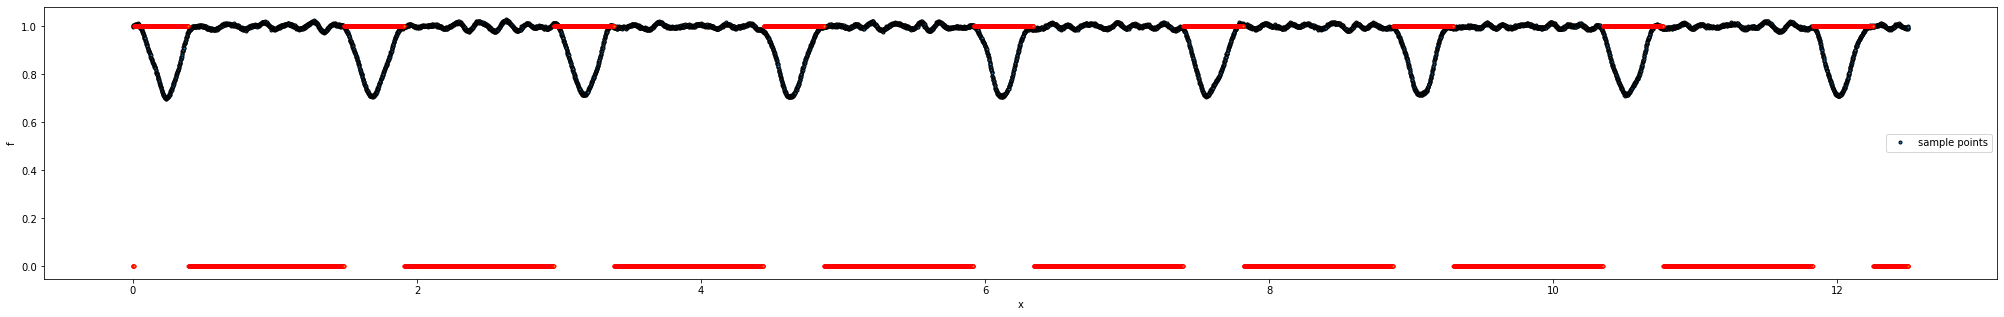

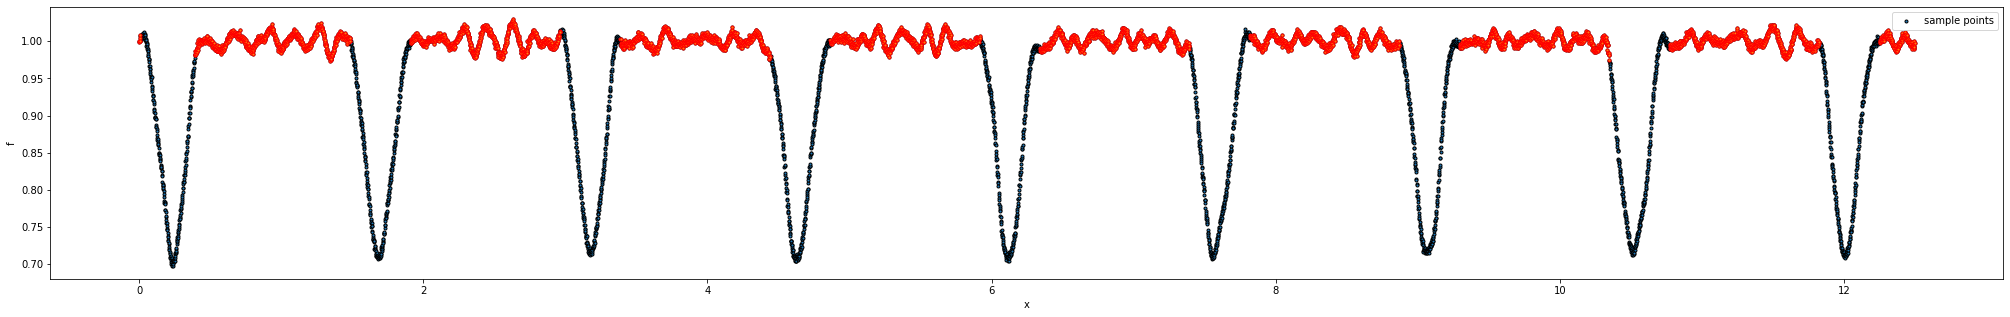

In [15]:
# Now store the timestamps of this gaps for our fitting procedure
X_gaps = X_part[Y_mask==1]

# And remove the observations at the gaps from X and Y
X_without_gaps = X_part[Y_mask==0]
Y_without_gaps = Y_part[Y_mask==0]

plotter.plot_data(X_part, Y_part, X_part, Y_mask)
plotter.plot_data(X_part, Y_part, X_without_gaps, Y_without_gaps)

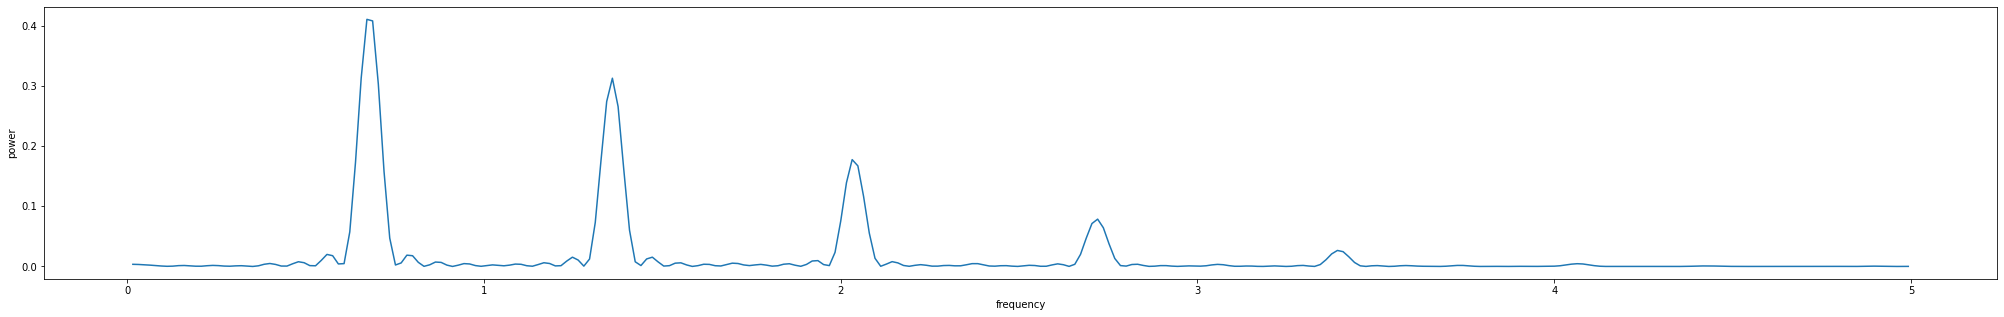

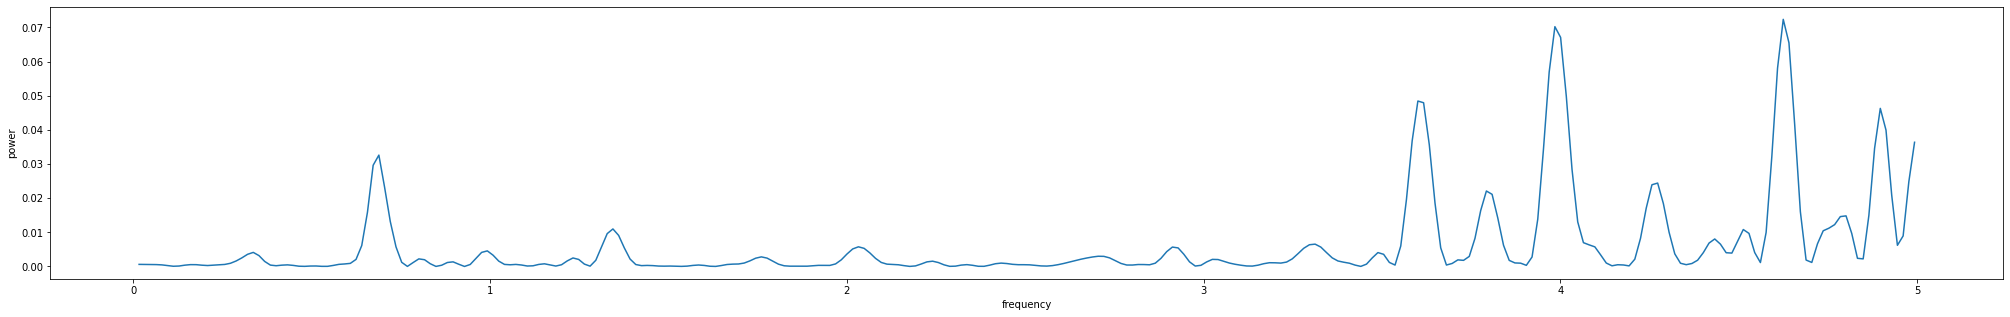

In [16]:
frequencies, power = plotter.plot_lomb_scargle_periodogram(X_part, Y_part, 0.0, 5)
frequencies, power = plotter.plot_lomb_scargle_periodogram(X_part_window, Y_part_window, 0.0, 5)

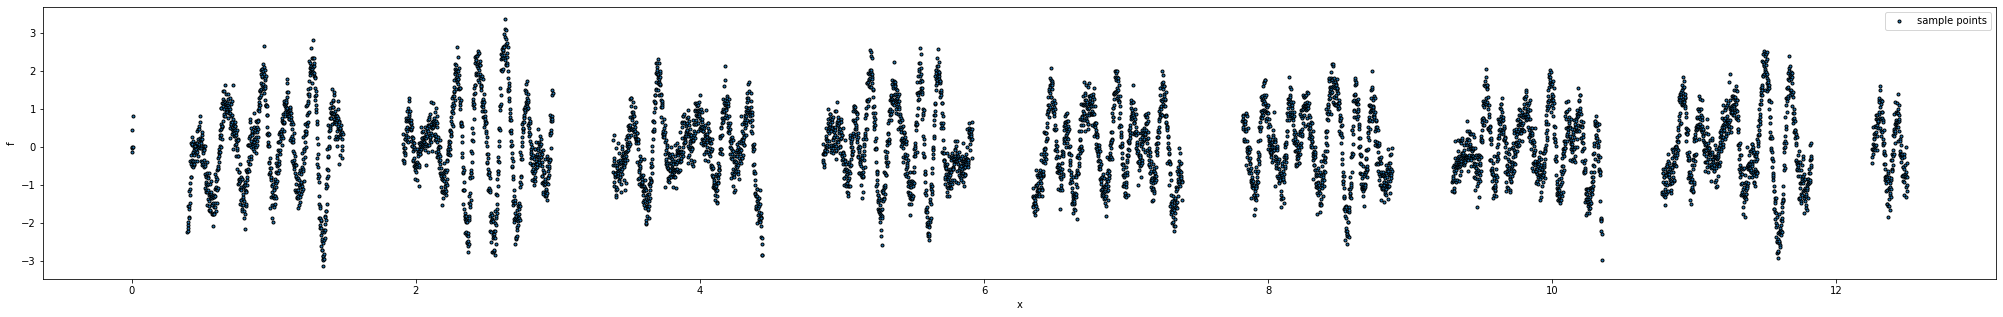

In [17]:
# !! It's important that we normalize *after* removing the E.B. signal, as that E.B. signal has a major impact on the mean
# In other words, if we normalize first, then remove the E.B., the remaining signal will be somewhere centered around +0.2
# We can not fit any kernel (RBF, Matern...) to a non-normalized signal!!
# normalize labels
mean, std, Y_part_window = experiment_util.normalize_mean(Y_part_window)
_, _, Y_part = experiment_util.normalize_mean(Y_part)
plotter.plot_data(X_part_window, Y_part_window)

Move data and models to the GPU

In [18]:
if USE_CUDA:
    X_part_window = X_part_window.cuda()
    X_part_smooth = X_part_smooth.cuda()
    Y_part_window = Y_part_window.cuda()
    model = model.cuda()
    likelihood = likelihood.cuda()

In [19]:
from gpytorch.priors import NormalPrior

# We will use the simplest form of GP model, exact inference
class ExactGPModel(gpytorch.models.ExactGP):
    def __init__(self, train_x, train_y, likelihood):
        super(ExactGPModel, self).__init__(train_x, train_y, likelihood)
        self.mean_module = gpytorch.means.ZeroMean()
        # RBF kernel for the uncorrelated noise
        self.covar_module = gpytorch.kernels.ScaleKernel(gpytorch.kernels.RBFKernel())
        # TODO: the length scale depends on the values on the X-axis
        self.covar_module.base_kernel.lengthscale=5*sample_period # 0.01

    def forward(self, x):
        mean_x = self.mean_module(x)
        covar_x = self.covar_module(x)
        return gpytorch.distributions.MultivariateNormal(mean_x, covar_x)

# initialize likelihood and model
likelihood = gpytorch.likelihoods.GaussianLikelihood()
model = ExactGPModel(X_part_window, Y_part_window, likelihood)

# As we are using float64 data, we need to convert our model to double
_ = model.double()
_ = likelihood.double()

In [20]:
training_iter = 75

# NOTE: you can not run this with 100 iterations as it will have large spikes
# in the gaps due to the length scale becoming very large
# TODO: should we set a prior on the length scale, with minimum length?

# Find optimal model hyperparameters
model.train()
likelihood.train()

# Use the adam optimizer on a subset of the hyperparameters
all_params = set(model.parameters())
optimizer = torch.optim.Adam(all_params, lr=0.15)

# "Loss" for GPs - the marginal log likelihood
mll = gpytorch.mlls.ExactMarginalLogLikelihood(likelihood, model)

for i in range(training_iter):
    # Zero gradients from previous iteration
    optimizer.zero_grad()
    # Output from model
    output = model(X_part_window)
    # Calc loss and backprop gradients
    loss = -mll(output, Y_part_window)
    loss.backward()
    print('Iter %d/%d - Loss: %.3f   Lengthscale: %.3f    noise: %.3f' % (
        i + 1, training_iter, loss.item(),
        model.covar_module.base_kernel.lengthscale,
        model.likelihood.noise.item()
    ))
    optimizer.step()

Iter 1/75 - Loss: 0.988   Lengthscale: 0.007    noise: 0.693
Iter 2/75 - Loss: 0.926   Lengthscale: 0.008    noise: 0.621
Iter 3/75 - Loss: 0.869   Lengthscale: 0.009    noise: 0.554
Iter 4/75 - Loss: 0.806   Lengthscale: 0.011    noise: 0.493
Iter 5/75 - Loss: 0.749   Lengthscale: 0.013    noise: 0.437
Iter 6/75 - Loss: 0.692   Lengthscale: 0.015    noise: 0.387
Iter 7/75 - Loss: 0.636   Lengthscale: 0.017    noise: 0.341
Iter 8/75 - Loss: 0.584   Lengthscale: 0.019    noise: 0.299
Iter 9/75 - Loss: 0.529   Lengthscale: 0.022    noise: 0.263
Iter 10/75 - Loss: 0.488   Lengthscale: 0.025    noise: 0.230
Iter 11/75 - Loss: 0.445   Lengthscale: 0.029    noise: 0.201
Iter 12/75 - Loss: 0.407   Lengthscale: 0.033    noise: 0.176
Iter 13/75 - Loss: 0.381   Lengthscale: 0.036    noise: 0.154
Iter 14/75 - Loss: 0.355   Lengthscale: 0.039    noise: 0.134
Iter 15/75 - Loss: 0.334   Lengthscale: 0.040    noise: 0.118
Iter 16/75 - Loss: 0.318   Lengthscale: 0.040    noise: 0.104
Iter 17/75 - Loss

In [21]:
# Get into evaluation (predictive posterior) mode
model.eval()
likelihood.eval()

GaussianLikelihood(
  (noise_covar): HomoskedasticNoise(
    (raw_noise_constraint): GreaterThan(1.000E-04)
  )
)

In [22]:
#plotter.plot_series(X_part_window.cpu().numpy()[100:400], Y_part_window.cpu().numpy()[100:400])

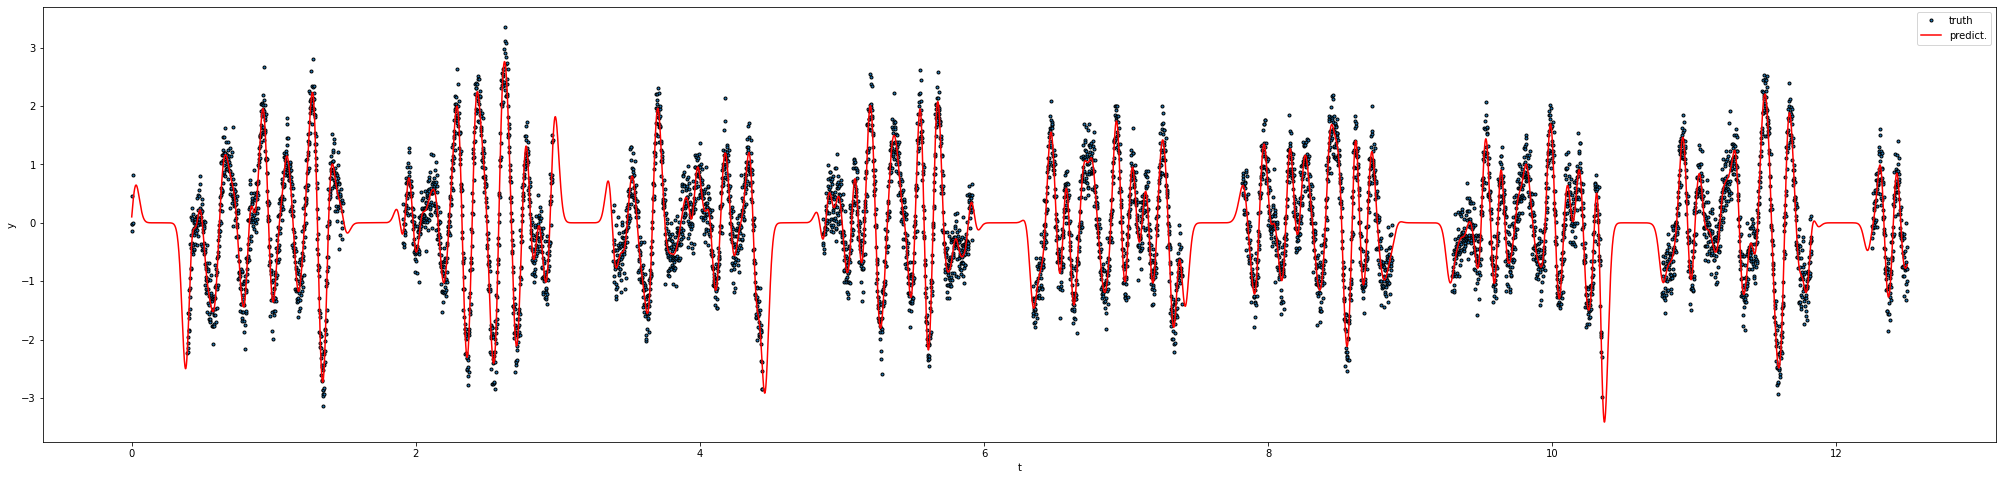

In [23]:
# Predict on the original X positions!
with torch.no_grad(), gpytorch.settings.fast_pred_var():
    Y_part_pred = likelihood(model(X_part))
    plotter.plot_series(X_part_window.cpu().numpy(), Y_part_window.cpu().numpy(), X_part.cpu().numpy(), Y_part_pred.mean.cpu().numpy())

In [24]:
print(model.covar_module.base_kernel.lengthscale)

tensor([[0.0309]], dtype=torch.float64, grad_fn=<SoftplusBackward0>)


# Correlation between the pulsation+noise data and the full data with E.B. removed

In [25]:
experiment_util.calculate_error(Y_part, Y_part_pred.mean.cpu())

TimeSeriesSimilarity(correlation=0.08925583006580791, rmse=1.2610088199977147)

In [26]:
Y_part.shape, Y_part_pred.mean.cpu().shape

(torch.Size([9000]), torch.Size([9000]))

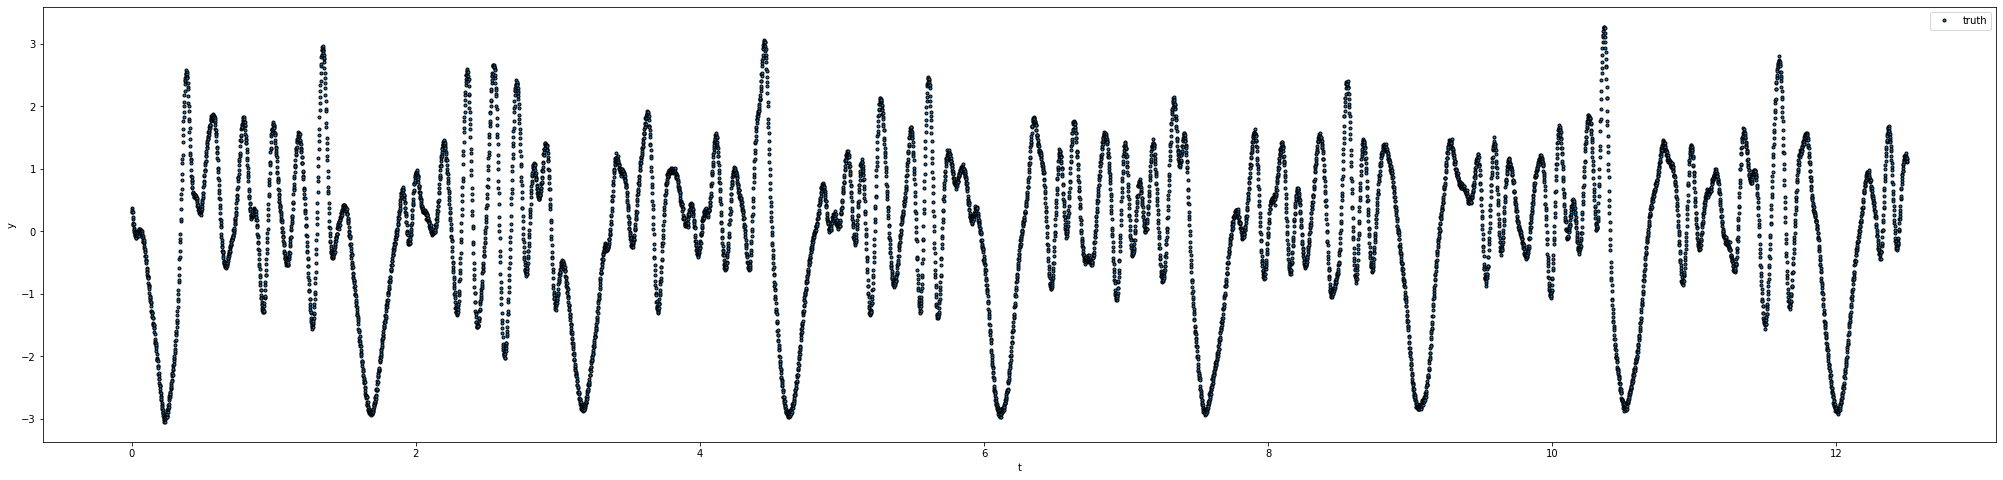

In [27]:
# Subtract the model pulsation signal from the full signal. This should give us the eclipses only, ideally with no noise!
plotter.plot_series(X_part, Y_part - Y_part_pred.mean.cpu().numpy())